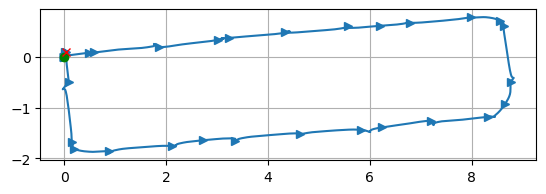

Difference between the initial and final position =  0.103045
Estimated total travelled distance =  22.191858


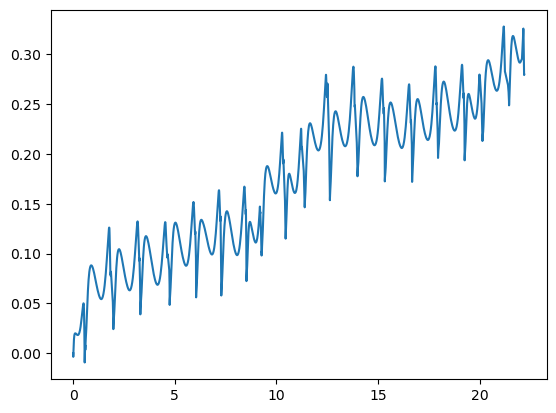

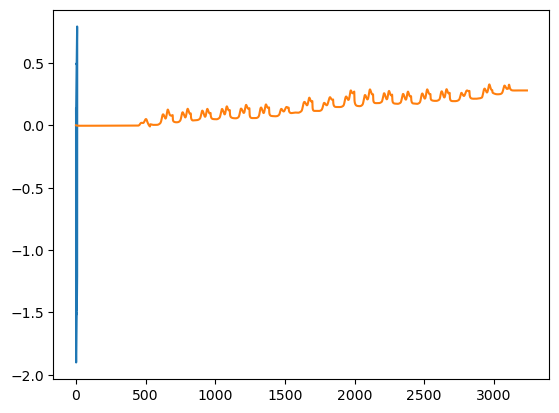

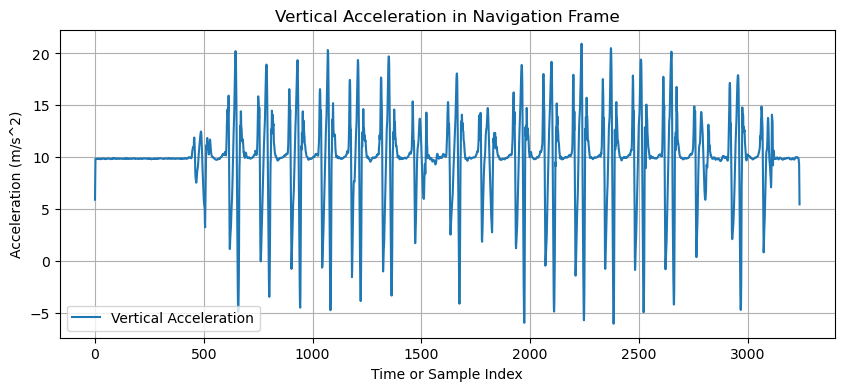

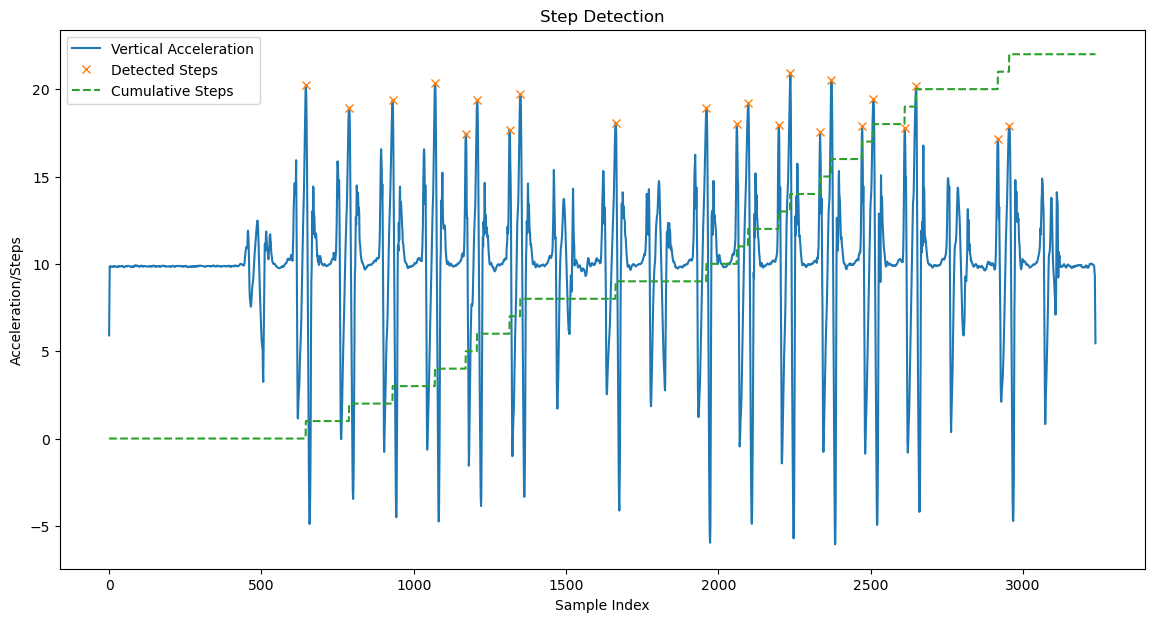

Total number of detected steps: 22


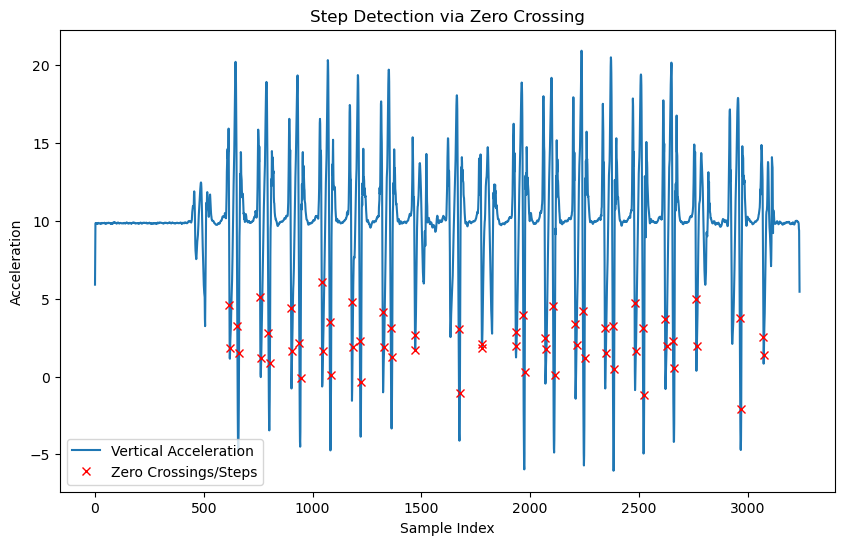

Total number of detected steps: 60


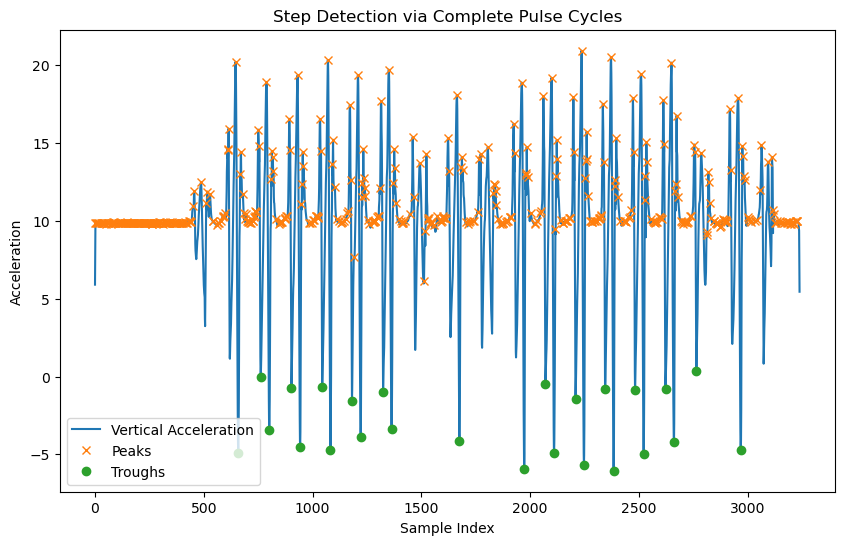

Total number of complete pulse cycles detected as steps: 25
Total number of detected steps: 2


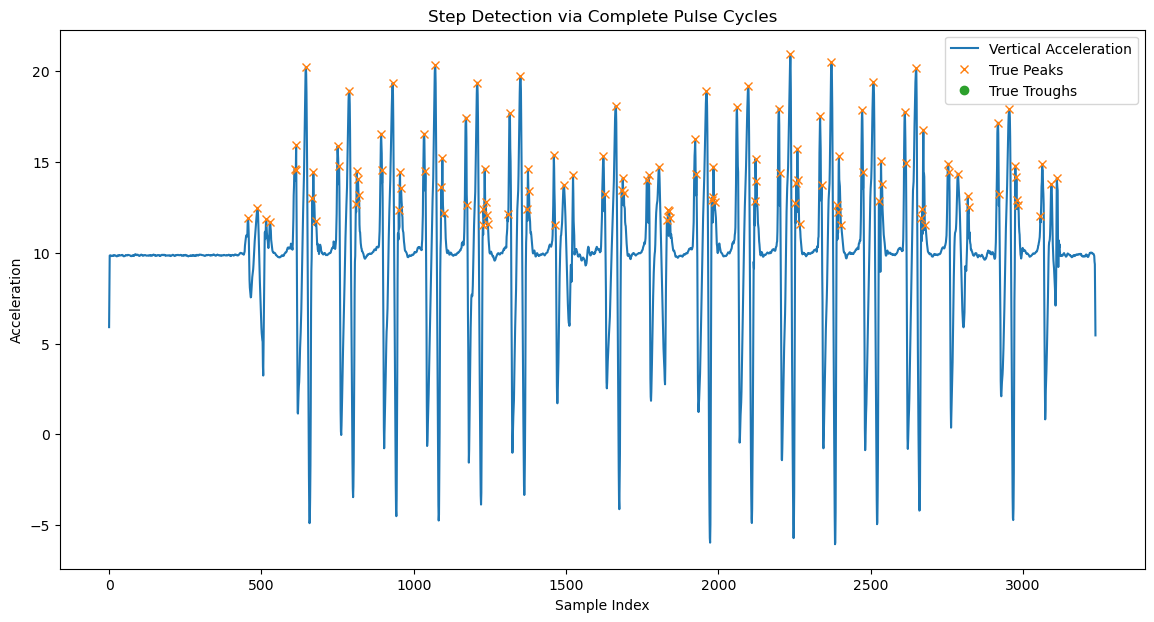

Total number of detected steps: 0


In [145]:
##An Inertial Navigation System - Extended Kalman Filter - ZUPT for Pedestrian Dead Reckoning (IEZ-PDR)An Inertial Navigation System - Extended Kalman Filter - ZUPT for Pedestrian Dead Reckoning (IEZ-PDR)
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
from scipy import linalg as lin
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('path_to_save_model/my_lstm_model.h5')

# Use model.predict(...) within your algorithm to make predictions on new data.



# Read data from file.
#samplePeriod = np.around(1/Fs, decimals=4) 

filePath = 'conf-3333-coleta04-02-06-21-5ds_03.csv' #YOU NEED TO VERIFY THIS LINE
#data = pd.read_csv(filePath, header = None, sep = ',', names=['mpu_id', 'ts', 'q.w', 'q.x', 'q.y', 'q.z', 'ax', 'ay', 'az', 'gx', 'gy', 'gz'])
data = pd.read_csv(filePath, header = None, sep = ',', names=['t', 'ax1', 'ay1', 'az1', 'gx1', 'gy1', 'gz1', 'ax2', 'ay2', 'az2', 'gx2', 'gy2', 'gz2'])


#LOW PASS FILTER 
#--------------------------------------------------------------------------------
# Apply the low pass filter to the accelerometer and gyroscope data
def moving_average_filter(data, window_size=5):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='same')

window_size = 5  # Adjust window_size based on your specific data
# Assuming columns 1-6 are your sensor data columns
for i in range(1, 13):  
    data.iloc[:, i] = moving_average_filter(data.iloc[:, i].values, window_size=window_size)
#--------------------------------------------------------------------------------


datasize = len(data.iloc[:, 0].values) # data_size = length(data.data)
#timestamp = (data.iloc[:,1].values).T # Timestamps of measurements.
#timestamp = (np.arange(0, datasize, 1/100)).T
g = 9.81 #Gravity 

# Accelerations is in sensor frame.
# Rates of turn is in sensor frame.

acc_scale_range = 3 # 0 for 2g, 1 for 4g, 2 for 8g and 3 for 16g
gyro_scale_range = 3 # 0 for 250, 1 for 500, 2 for 1000 and 3 for 2000
sensor = 2

if(acc_scale_range==0):
    acc_factor = 16384
elif(acc_scale_range==1):
    acc_factor = 8192
elif(acc_scale_range==2):
    acc_factor = 4096
elif(acc_scale_range==3):
    acc_factor = 2048

if(gyro_scale_range==0):
    gyro_factor = 131
elif(gyro_scale_range==1):
    gyro_factor = 65.5
elif(gyro_scale_range==2):
    gyro_factor = 32.8
elif(gyro_scale_range==3):
    gyro_factor = 16.4
    

if (sensor == 1): 
    acc_s = ((data.iloc[:,1:4].values/acc_factor)*g).T
    gyro_s = (np.deg2rad(data.iloc[:,4:7].values/gyro_factor)).T
elif (sensor == 2):
    acc_s = ((data.iloc[:,7:10].values/acc_factor)*g).T
    gyro_s = (np.deg2rad(data.iloc[:,10:13].values/gyro_factor)).T
    
#Montrel comment, The g_array line transforms the body frame into the fixed frame (using acceletation measurements which include gravity) 
datasize = len(data.iloc[:, 0].values)
    
g_array = np.array([[0.0, 0.0, g]]).T

# Calculate gyro bias
# Lots of datasets starts from stationary position, so a simple mean is suffice to initial gyro bias
gyro_mean = np.mean(gyro_s[:,0:200], 1)
gyro_bias = np.matrix([gyro_mean[0], gyro_mean[1], gyro_mean[2]]).T
#gyro_bias = np.matrix([0, 0, 0]).T
acc_mean = np.mean(acc_s[:,0:200], 1)
#acc_bias = np.matrix([acc_mean[0], acc_mean[1], acc_mean[2]-g]).T
acc_bias = np.matrix([0, 0, 0]).T

# Initialise parameters.
# Orientation from accelerometers. Sensor is assumed to be stationary.
# Another assumption is that x-axis is aligned with the pedestrian's foward direction

init_a = np.mean(acc_s[:,0:200], 1)

pitch = -np.arcsin(init_a[0]/g)
roll = np.arctan(init_a[1]/init_a[2])
yaw = 0.0
#yaw = -0.3 #it is possible to set your own yaw if you know it by any means

# Orientation Matrix (this is already C.T)
C = np.array([
    [np.cos(pitch)*np.cos(yaw), (np.sin(roll)*np.sin(pitch)*np.cos(yaw))-(np.cos(roll)*np.sin(yaw)), (np.cos(roll)*np.sin(pitch)*np.cos(yaw))+(np.sin(roll)*np.sin(yaw))],
    [np.cos(pitch)*np.sin(yaw), (np.sin(roll)*np.sin(pitch)*np.sin(yaw))+(np.cos(roll)*np.cos(yaw)), (np.cos(roll)*np.sin(pitch)*np.sin(yaw))-(np.sin(roll)*np.cos(yaw))],
    [-np.sin(pitch), np.sin(roll)*np.cos(pitch), np.cos(roll)*np.cos(pitch)]
    ])
C_prev = C

# Create arrays to storage some data
heading = np.zeros((1,datasize))
heading[0,0] = yaw

# Preallocate storage for accelerations in navigation frame.
acc_n = np.zeros((3,datasize))
acc_n[:,0] = C@acc_s[:,0]


# Preallocate storage for velocity (in navigation frame).
# Initial velocity assumed to be zero.
vel_n = np.zeros((3,datasize)) 

# Preallocate storage for position (in navigation frame).
# Initial position arbitrarily set to the origin.
pos_n = np.zeros((3,datasize))

# Preallocate storage for distance travelled used for altitude plots.
distance = np.zeros((1,datasize))

# Error covariance matrix.
P = np.zeros((9,9))

# Process noise parameter, gyroscope and accelerometer noise.
sigma_omega = 0.01
sigma_a = 0.1
#sigma_omega = 0.0006
#sigma_a = 0.003

# ZUPT measurement matrix.
#H = np.eye(3, 9, k = 6)
H = np.block([
            [np.zeros((3,3)), np.zeros((3,3)), np.eye((3))],
            ])

# ZUPT measurement noise covariance matrix.
sigma_v = 0.01
R = np.diag([sigma_v, sigma_v, sigma_v])**2

# Stance detection starts here
# Compute accelerometer magnitude
acc_mag = np.around(np.sqrt(acc_s[0]**2 + acc_s[1]**2 + acc_s[2]**2), decimals=4)
# Compute gyroscope magnitude
gyro_mag = np.around(np.sqrt((gyro_s[0])**2 + (gyro_s[1])**2 + (gyro_s[2])**2), decimals=4)

acc_stationary_threshold_H = 11
acc_stationary_threshold_L = 9
gyro_stationary_threshold = 0.6

stationary_acc_H = (acc_mag < acc_stationary_threshold_H)
stationary_acc_L = (acc_mag > acc_stationary_threshold_L)
stationary_acc = np.logical_and(stationary_acc_H, stationary_acc_L) #C1
stationary_gyro = (gyro_mag < gyro_stationary_threshold) #C2

stationary = np.logical_and(stationary_acc, stationary_gyro)

# this window is necessary to clean stationary array from false stance detection
W = 10
for k in range(datasize-W+1):
    if (stationary[k] == True) and (stationary[k+W-1] == True):
        stationary[k:k+W] = np.ones((W))
        
for k in range(datasize-W+1):
    if (stationary[k] == False) and (stationary[k+W-1] == False):
        stationary[k:k+W] = np.zeros((W))
# Stance detection ends here
       
# Main Loop
for t in range(1, datasize):
    ### Start INS (transformation, double integration) ### (1)
    dt = 1/100

    # Remove bias from gyro measurements.
    gyro_s1 = gyro_s[:,t:t+1] - gyro_bias
    
    # Skew-symmetric matrix for angular rates
    ang_rate_matrix = np.array([[0,            -gyro_s1[2,0], gyro_s1[1,0]],
                                [gyro_s1[2,0],   0,           -gyro_s1[0,0]],
                                [-gyro_s1[1,0],  gyro_s1[0,0],   0]])
    # Update the orientation estimation (4)
    C = C_prev@(2*np.eye(3)+(ang_rate_matrix*dt))@lin.inv((2*np.eye(3)-(ang_rate_matrix*dt)))
    
    # Transforming the acceleration from sensor frame to navigation frame.
    acc_n[:,t:t+1] = 0.5*(C + C_prev)@(acc_s[:,t:t+1]-acc_bias)
    #acc_n[:,t:t+1] = 0.5*(C + C_prev)@acc_s[:,t:t+1]

    
    # Skew-symmetric cross-product operator matrix formed from the n-frame accelerations.
    S = np.array([[0,           -acc_n[2,t],   acc_n[1,t]],
                  [acc_n[2,t],  0,            -acc_n[0,t]],
                  [-acc_n[1,t],  acc_n[0,t],   0]])
    
    # Velocity and position estimation using trapeze integration. (6-7)
    vel_n[:,t:t+1] = (vel_n[:,t-1:t] + ((acc_n[:,t:t+1] - g_array)+(acc_n[:,t-1:t] - g_array))*dt/2)
    pos_n[:,t:t+1] = (pos_n[:,t-1:t] + (vel_n[:,t:t+1] + vel_n[:,t-1:t])*dt/2)
    
    # State transition matrix (or fundamental matrix). (9)
    F = np.block([
            [np.eye((3)),     np.zeros((3,3)),    np.zeros((3,3))], # attitude
            [np.zeros((3,3)), np.eye((3)),        dt*np.eye((3))],  # position
            [-dt*S,           np.zeros((3,3)),    np.eye((3))]      # velocity
            ])
        
    # Compute the process noise covariance Q.
    Q = (np.diag([sigma_omega, sigma_omega, sigma_omega, 0, 0, 0, sigma_a, sigma_a, sigma_a])*dt)**2
    
    # Propagate the error covariance matrix.
    P = F@P@F.T + Q
    ### End INS ###

    # Zero-velocity updates.
    if (stationary[t:t+1]):
        ### Start Kalman filter zero-velocity update %%%
        # Compute Kalman gain.
        K = P@H.T@lin.inv(H@P@H.T + R)
        
        # Compute the state errors state.
        # Update the filter state.
        delta_x = K@vel_n[:,t:t+1]
        
        # Update the error covariance matrix
        P = (np.eye((9)) - K@H)@P
        
        # Extract errors from the KF state.
        attitude_error = delta_x[0:3]#[:,np.newaxis]
        pos_error = delta_x[3:6]#[:,np.newaxis]
        vel_error = delta_x[6:9]#[:,np.newaxis]
        ### End Kalman filter zero-velocity update ###
        
        ### Apply corrections to INS estimates. ###
        # Skew-symmetric matrix for small angles to correct orientation.
        ang_matrix = -np.array([
                    [0,                   -attitude_error[2,0],   attitude_error[1,0]],
                    [attitude_error[2,0],  0,                      -attitude_error[0,0]],
                    [-attitude_error[1,0],  attitude_error[0,0],    0]
                    ])
        # Correct orientation estimation. (17)
        C = (2*np.eye(3)+(ang_matrix))@lin.inv((2*np.eye(3)-(ang_matrix)))@C
        
        # Correct position and velocity based on Kalman error estimates.
        vel_n[:,t:t+1]=vel_n[:,t:t+1]-vel_error
        pos_n[:,t:t+1]=pos_n[:,t:t+1]-pos_error
        
    heading[0,t] = np.arctan2(C[1,0], C[0,0]) # Estimate and save the yaw of the sensor (different from the direction of travel). Unused here but potentially useful for orienting a GUI correctly.
    C_prev = C # Save orientation estimate, required at start of main loop.
    
    # Compute horizontal distance.
    distance[0,t:t+1] = distance[0,t-1:t] + np.sqrt((pos_n[0,t:t+1]-pos_n[0,t-1:t])**2 + (pos_n[1,t:t+1]-pos_n[1,t-1:t])**2)

    

# Rotate position estimates (just for better visualization if needed) and plot.
angle = np.deg2rad(0)
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)]
    ])
pos_r = np.zeros((2,datasize))
for idx in range(0, datasize):
    pos_r[:,idx] = rotation_matrix@np.array([pos_n[0,idx], pos_n[1,idx]])

plt.plot(pos_r[0,:],pos_r[1,:], marker='>', markevery=100)
plt.plot(pos_r[0,0],pos_r[1,0], marker= 'o', color = 'green') #start mark
plt.plot(pos_r[0,-1],pos_r[1,-1], marker = 'x', color = 'red') #end mark
ax = plt.gca()
ax.grid()
ax.set_aspect(1) #sets the height to width ratio to 1
plt.show()

a = np.array([pos_r[0,0],pos_r[1,0]])
b = np.array([pos_r[0,-1],pos_r[1,-1]])
c = np.linalg.norm(a-b)
print('Difference between the initial and final position = ',np.around(c, 6))

soma = 0
for t in range(1,pos_r.shape[1]):
    a = np.array([pos_r[0,t-1:t],pos_r[1,t-1:t]])
    b = np.array([pos_r[0,t:t+1],pos_r[1,t:t+1]])
    c = np.linalg.norm(b-a)
    soma = soma + c
print('Estimated total travelled distance = ', np.around(soma, 6))
#print(np.linalg.norm(a-b)/soma)

#a 2D plot
plt.plot(distance[0,:],pos_n[2,:])
#plt.plot(x,y)
plt.show()

#here a 3D plot
fig = plt.figure()
ax = p3.Axes3D(fig)
data_x = pos_r[0,:]
data_y = pos_r[1,:]
data_z = pos_n[2,:]
plt.plot(data_x,data_y,data_z)


#vertical acceleration after transformed to navigation frame
#--------------------------------------------------------------------------------

# Make sure to replace 'acc_n' with the actual transformed acceleration data array from your code.
# The below 'acc_n' is placeholder data and should be replaced with your actual data.

# Extract the vertical acceleration component (assuming it's the Z-axis, index 2)
vertical_acceleration = acc_n[2, :]

# Generate a time array or sample index
time_or_sample_index = np.arange(vertical_acceleration.shape[0])

# Plotting    
plt.figure(figsize=(10, 4))
plt.plot(time_or_sample_index, vertical_acceleration, label='Vertical Acceleration')
plt.title('Vertical Acceleration in Navigation Frame')
plt.xlabel('Time or Sample Index')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()
#--------------------------------------------------------------------------------

#PEAK DETECTION
#--------------------------------------------------------------------------------

# Step 1: Detect peaks
peaks, _ = find_peaks(vertical_acceleration, height=17)  # Adjust height as needed

# Step 2: Count steps
total_steps = len(peaks)

# Optional: Create an array for total steps over time for visualization
steps_over_time = np.zeros_like(vertical_acceleration)
steps_over_time[peaks] = 1
cumulative_steps = np.cumsum(steps_over_time)

# Step 3: Plotting
plt.figure(figsize=(14, 7))
plt.plot(vertical_acceleration, label='Vertical Acceleration')
plt.plot(peaks, vertical_acceleration[peaks], "x", label='Detected Steps')
plt.plot(cumulative_steps, label='Cumulative Steps', linestyle='--')
plt.title('Step Detection')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration/Steps')
plt.legend()
plt.show()

print(f"Total number of detected steps: {total_steps}")
#--------------------------------------------------------------------------------



#ZERO-CROSSING DETECTION
#--------------------------------------------------------------------------------
# Define the crossing level
crossing_level = 2


# Calculate zero crossings
zero_crossings = np.where(np.diff(np.sign(vertical_acceleration - crossing_level)))[0]

# Basic filtering to identify steps
# This might include looking at the time between zero crossings to filter out noise
# For simplicity, this example treats each zero crossing as a step

# Count steps
total_steps = len(zero_crossings)

# Plot the data and zero crossings
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vertical_acceleration, label='Vertical Acceleration')
plt.plot(zero_crossings, vertical_acceleration[zero_crossings], "rx", label='Zero Crossings/Steps')
plt.title('Step Detection via Zero Crossing')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

print(f"Total number of detected steps: {total_steps}")
#--------------------------------------------------------------------------------


#THRESHOLD BASED TECHNIQUES 
#--------------------------------------------------------------------------------


# Detect peaks (top of the pulse cycle)
peaks, _ = find_peaks(vertical_acceleration, height=0.5)  # adjust height as needed

# Invert the signal to detect troughs (bottom of the pulse cycle)
inverted_signal = -vertical_acceleration
troughs, _ = find_peaks(inverted_signal, height=-0.5)  # adjust height as needed

# Combine and sort peaks and troughs
all_points = np.sort(np.concatenate((peaks, troughs)))

# Identify complete cycles (a peak followed by a trough and another peak)
steps = 0
for i in range(1, len(all_points)-1):
    if all_points[i-1] in peaks and all_points[i] in troughs and all_points[i+1] in peaks:
        steps += 1

# Plotting for visualization
plt.figure(figsize=(10, 6))
plt.plot(vertical_acceleration, label='Vertical Acceleration')
plt.plot(peaks, vertical_acceleration[peaks], "x", label='Peaks')
plt.plot(troughs, vertical_acceleration[troughs], "o", label='Troughs')
plt.legend()
plt.title('Step Detection via Complete Pulse Cycles')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration')
plt.show()

print(f"Total number of complete pulse cycles detected as steps: {steps}")








#THRESHOLD BASED TECHNIQUES 
#--------------------------------------------------------------------------------


peak_threshold = 11.5  

# Define absolute height thresholds
peak_height_threshold = 11.5
trough_height_threshold = -4.0

# Pre-filter the signal for peaks and troughs
peaks = np.where(vertical_acceleration > peak_height_threshold)[0]
troughs = np.where(vertical_acceleration < trough_height_threshold)[0]

# Detect peaks (up phase of the pulse)
peaks, _ = find_peaks(vertical_acceleration, height= 11.5)  # Adjust 'height' as necessary

# Invert the signal to detect troughs (down phase of the pulse)
troughs, _ = find_peaks(-vertical_acceleration, height= 4)  # Adjust 'height' for troughs

# Combine peaks and troughs and sort them
all_points = np.sort(np.concatenate((peaks, troughs)))

# Identify complete pulses
complete_pulses = []
for i in range(1, len(all_points)-1):
    if all_points[i-1] in peaks and all_points[i] in troughs and all_points[i+1] in peaks:
        # Ensure there's a return to baseline before considering it a complete pulse
        if np.all(np.abs(vertical_acceleration[all_points[i]:all_points[i+1]]) < 10):  # Adjust baseline threshold
            complete_pulses.append(all_points[i])

total_steps = len(complete_pulses)

print(f"Total number of detected steps: {total_steps}")






# Assuming 'vertical_acceleration' contains your vertical acceleration data
# vertical_acceleration = np.array([...])

# Define a threshold for peak detection based on your data analysis
peak_threshold = 11.5  # Adjust based on your data

# Detect peaks with at least 'peak_threshold' height above their surroundings
peaks, properties = find_peaks(vertical_acceleration, height=peak_threshold)

# Now filter out peaks that are not actually above the 'peak_threshold' value
true_peaks = peaks[properties["peak_heights"] > peak_threshold]

# Detect troughs by inverting the signal and using the same method
troughs, properties = find_peaks(-vertical_acceleration, height=-peak_threshold)
true_troughs = troughs[properties["peak_heights"] > peak_threshold]

# Identify complete pulse cycles
steps = 0
for i in range(1, len(true_peaks) - 1):
    # Look for a trough between two peaks
    troughs_between_peaks = [trough for trough in true_troughs if true_peaks[i-1] < trough < true_peaks[i]]
    
    if troughs_between_peaks:
        # If there is at least one trough between the peaks, consider this a step
        steps += 1

# Optional: Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(vertical_acceleration, label='Vertical Acceleration')
plt.plot(true_peaks, vertical_acceleration[true_peaks], "x", label='True Peaks')
plt.plot(true_troughs, vertical_acceleration[true_troughs], "o", label='True Troughs')
plt.title('Step Detection via Complete Pulse Cycles')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

print(f"Total number of detected steps: {steps}")


